In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Veri yolu (Docker içi)
DATASET_PATH = '/app/data/Dataset'

IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32

# Verileri Yükle
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH, validation_split=0.2, subset="training", seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH, validation_split=0.2, subset="validation", seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [36]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', name="last_conv_layer"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Eğitimi başlat (Daha önce 10 yapmıştık, hızlıca 5 de yapabilirsin)
model.fit(train_ds, validation_data=val_ds, epochs=10)import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_gradcam(img_array, model, last_conv_layer_name):
    # 1. Modelin iç katmanlarını kullanarak yeni bir Fonksiyonel model oluşturalım
    # Bu yöntem 'sequential' katman hatasını atlamamızı sağlar
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    # Girişten son evrişim katmanına ve son çıkışa giden yolları belirleyelim
    # Keras 3 uyumluluğu için modelin katman giriş/çıkışlarını kullanıyoruz
    grad_model = tf.keras.Model(
        model.inputs, 
        [last_conv_layer.output, model.output]
    )

    # 2. Seçilen resim için gradyanları izleyelim
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # Tahmin edilen en yüksek olasılıklı sınıfı alalım
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Son evrişim katmanındaki gradyanları hesaplayalım
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 4. Ağırlıkları (vektör bazlı) normalize edelim
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Isı haritasını (heatmap) oluşturalım
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Görselleştirme için 0-1 arasına normalize edelim
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- GÖRSELLEŞTİRME ---
# Test verisinden bir örnek alalım
image_batch, label_batch = next(iter(val_ds))

# Resim üzerinde modelin 'bakışını' simüle edelim
img = image_batch[0].numpy().astype("uint8")
heatmap = get_gradcam(np.array([image_batch[0]]), model, "last_conv_layer")

# Isı haritasını orijinal resim boyutuna getirip renklendirelim
heatmap_img = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_img = np.uint8(255 * heatmap_img)
heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

# Orijinal resimle %60 şeffaflıkta birleştirelim
output_img = cv2.addWeighted(img, 0.6, heatmap_img, 0.4, 0)

plt.figure(figsize=(8, 8))
plt.imshow(output_img)
plt.title(f"Teşhis: {class_names[label_batch[0]]}\nModelin Odaklandığı Klinik Alan (XAI)")
plt.axis("off")
plt.show()

SyntaxError: invalid syntax (1656341333.py, line 19)

2026-02-16 13:28:22.438992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


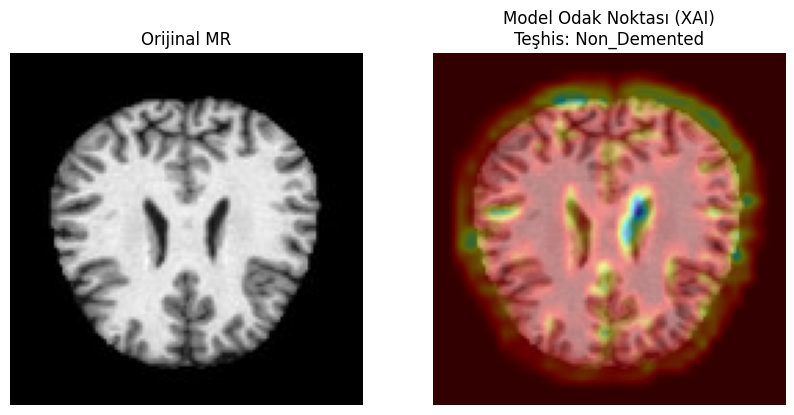

In [37]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_gradcam_v2(img_array, original_model, last_conv_layer_name):
    # 1. Yeni bir Giriş katmanı tanımlayalım
    img_input = tf.keras.Input(shape=(128, 128, 3))
    
    # 2. Sequential modelin katmanlarını manuel olarak birbirine bağlayalım
    # Bu adım 'never been called' hatasını tamamen ortadan kaldırır.
    x = img_input
    target_layer_output = None
    
    for layer in original_model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            target_layer_output = x
            
    # 3. Girişten hem hedef katmana hem de son çıkışa giden yeni bir model kuralım
    grad_model = tf.keras.Model(img_input, [target_layer_output, x])

    # 4. Gradyan takibi
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 5. Gradyanları ve kanal ağırlıklarını hesapla
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 6. Isı haritasını oluştur
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize et
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# --- UYGULAMA ---
# Test setinden bir örnek alalım
image_batch, label_batch = next(iter(val_ds))
img = image_batch[0].numpy().astype("uint8")

# Grad-CAM Isı Haritasını Oluştur (Yeni fonksiyonu çağırıyoruz)
try:
    heatmap = get_gradcam_v2(np.array([image_batch[0]]), model, "last_conv_layer")
    
    # Isı haritasını işle ve birleştir
    heatmap_img = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_img = np.uint8(255 * heatmap_img)
    heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)
    output_img = cv2.addWeighted(img, 0.6, heatmap_img, 0.4, 0)

    # GÖRSELLEŞTİRME
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Orijinal MR")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output_img)
    plt.title(f"Model Odak Noktası (XAI)\nTeşhis: {class_names[label_batch[0]]}")
    plt.axis("off")
    plt.show()

except Exception as e:
    print(f"Hâlâ bir pürüz var: {e}")